<a href="https://colab.research.google.com/github/nirmalaselvaraj963-sys/ml-work/blob/main/text_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd

In [15]:
from google.colab import files

# Upload your WhatsApp exported file (.zip or .txt)
uploaded = files.upload()


Saving WhatsApp Chat with Tamil AI Data Science Community .txt to WhatsApp Chat with Tamil AI Data Science Community  (2).txt


In [16]:
import zipfile, os

zip_path = "/content/WhatsApp Chat with Tamil AI Data Science Community .zip"   # your uploaded file
extract_path = "/content/data"               # where to unzip

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['WhatsApp Chat with Tamil AI Data Science Community .txt']


In [17]:
# Parse the WhatsApp chat data
import re
from datetime import datetime

def parse_whatsapp_chat(text_content):
    lines = text_content.split('\n')
    messages = []
    current_date = None

    for line in lines:
        # Check if line starts with a date pattern (e.g., "2/26/25, 8:25 PM")
        date_match = re.match(r'(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2} [AP]M)', line)

        if date_match:
            current_date = date_match.group(1)
            time_str = date_match.group(2)
            remaining_text = line[date_match.end():].strip()

            # Split sender and message
            if ' - ' in remaining_text:
                sender_part, message = remaining_text.split(' - ', 1)
                messages.append({
                    'date': current_date,
                    'time': time_str,
                    'sender': sender_part.strip(),
                    'message': message.strip(),
                    'datetime': datetime.strptime(f"{current_date} {time_str}", "%m/%d/%y %I:%M %p")
                })
            else:
                # System messages or group events
                messages.append({
                    'date': current_date,
                    'time': time_str,
                    'sender': 'System',
                    'message': remaining_text.strip(),
                    'datetime': datetime.strptime(f"{current_date} {time_str}", "%m/%d/%y %I:%M %p")
                })
        elif messages and current_date:
            # Continuation of previous message
            messages[-1]['message'] += ' ' + line.strip()

    return messages

# Load and parse the data
with open('WhatsApp Chat with Tamil AI Data Science Community .txt', 'r', encoding='utf-8') as file:
    chat_content = file.read()

messages = parse_whatsapp_chat(chat_content)
df = pd.DataFrame(messages)

print(f"Total messages: {len(df)}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
df.head()

Total messages: 4328
Date range: 2025-02-06 11:45:00 to 2025-09-22 19:57:00


,date,time,sender,message,datetime
0,2/26/25,8:25 PM,System,- Messages and calls are end-to-end encrypted....,2025-02-26 20:25:00
1,2/6/25,11:45 AM,System,"- ~ Thiru created group ""Tamil AI Data Science...",2025-02-06 11:45:00
2,2/26/25,8:25 PM,System,- You joined using this group's invite link,2025-02-26 20:25:00
3,2/26/25,8:31 PM,System,- +91 75503 62274: Bro data analytics roadmap ...,2025-02-26 20:31:00
4,2/26/25,8:31 PM,System,- +91 63806 54780: Will post bro,2025-02-26 20:31:00


In [18]:
# Basic dataset info
print("=== DATASET OVERVIEW ===")
print(f"Total messages: {len(df):,}")
print(f"Date range: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}")
print(f"Duration: {(df['datetime'].max() - df['datetime'].min()).days} days")
print(f"Unique senders: {df['sender'].nunique()}")

# Check for missing values
print(f"\n=== DATA QUALITY ===")
print(f"Missing messages: {df['message'].isnull().sum()}")
print(f"Empty messages: {df['message'].str.strip().eq('').sum()}")

# Remove empty messages
df = df[df['message'].str.strip().ne('')]

=== DATASET OVERVIEW ===
Total messages: 4,328
Date range: 2025-02-06 to 2025-09-22
Duration: 228 days
Unique senders: 30

=== DATA QUALITY ===
Missing messages: 0
Empty messages: 0


In [19]:
# Extract message types and characteristics
def categorize_message(message):
    message_lower = message.lower()

    # URL detection
    if 'http' in message_lower or '.com' in message_lower or 'www.' in message_lower:
        return 'URL'

    # Media detection
    if '<media omitted>' in message_lower:
        return 'Media'

    # Question detection
    if any(q_word in message_lower for q_word in ['?', 'help', 'doubt', 'sollunga', 'suggest', 'recommend']):
        return 'Question'

    # Code/technical terms
    tech_terms = ['python', 'ai', 'ml', 'dataset', 'model', 'algorithm', 'github', 'colab', 'import', 'def ']
    if any(term in message_lower for term in tech_terms):
        return 'Technical'

    return 'General'

df['message_type'] = df['message'].apply(categorize_message)
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()

# Extract phone numbers from sender names
df['is_phone_number'] = df['sender'].str.contains(r'\+\d{2,}|\d{10}', na=False)
df['clean_sender'] = df['sender'].apply(lambda x: 'User' if re.search(r'\+\d{2,}|\d{10}', str(x)) else x)

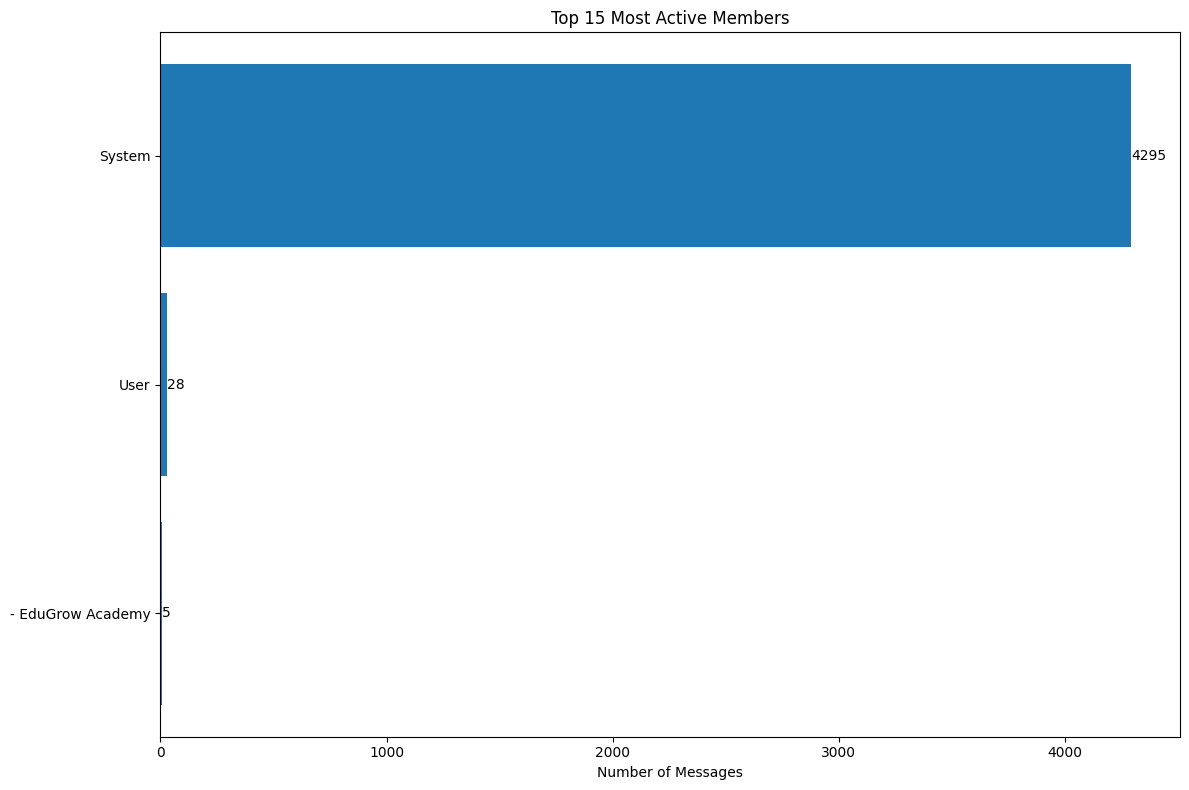

Top 5 senders contribute 100.0% of all messages


In [21]:
# Top senders analysis
import matplotlib.pyplot as plt

top_senders = df['clean_sender'].value_counts().head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(top_senders.index, top_senders.values)
plt.xlabel('Number of Messages')
plt.title('Top 15 Most Active Members')
plt.gca().invert_yaxis()

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

print(f"Top 5 senders contribute {top_senders.head(5).sum()/len(df)*100:.1f}% of all messages")

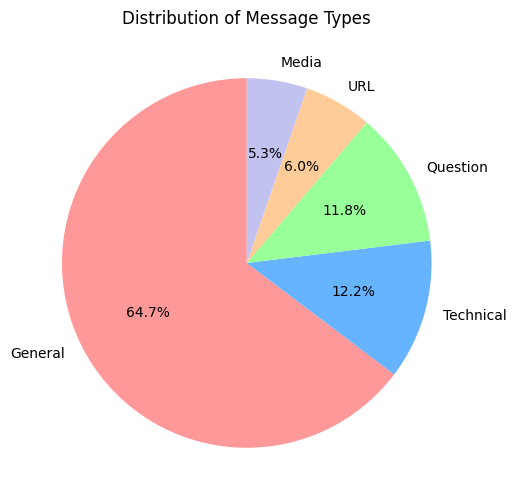

Message Type Breakdown:
General: 2800 messages (64.7%)
Technical: 530 messages (12.2%)
Question: 511 messages (11.8%)
URL: 258 messages (6.0%)
Media: 229 messages (5.3%)


In [22]:
import matplotlib.pyplot as plt

# Message type distribution
msg_type_dist = df['message_type'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']
plt.pie(msg_type_dist.values, labels=msg_type_dist.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribution of Message Types')
plt.show()

print("Message Type Breakdown:")
for msg_type, count in msg_type_dist.items():
    percentage = (count / len(df)) * 100
    print(f"{msg_type}: {count} messages ({percentage:.1f}%)")

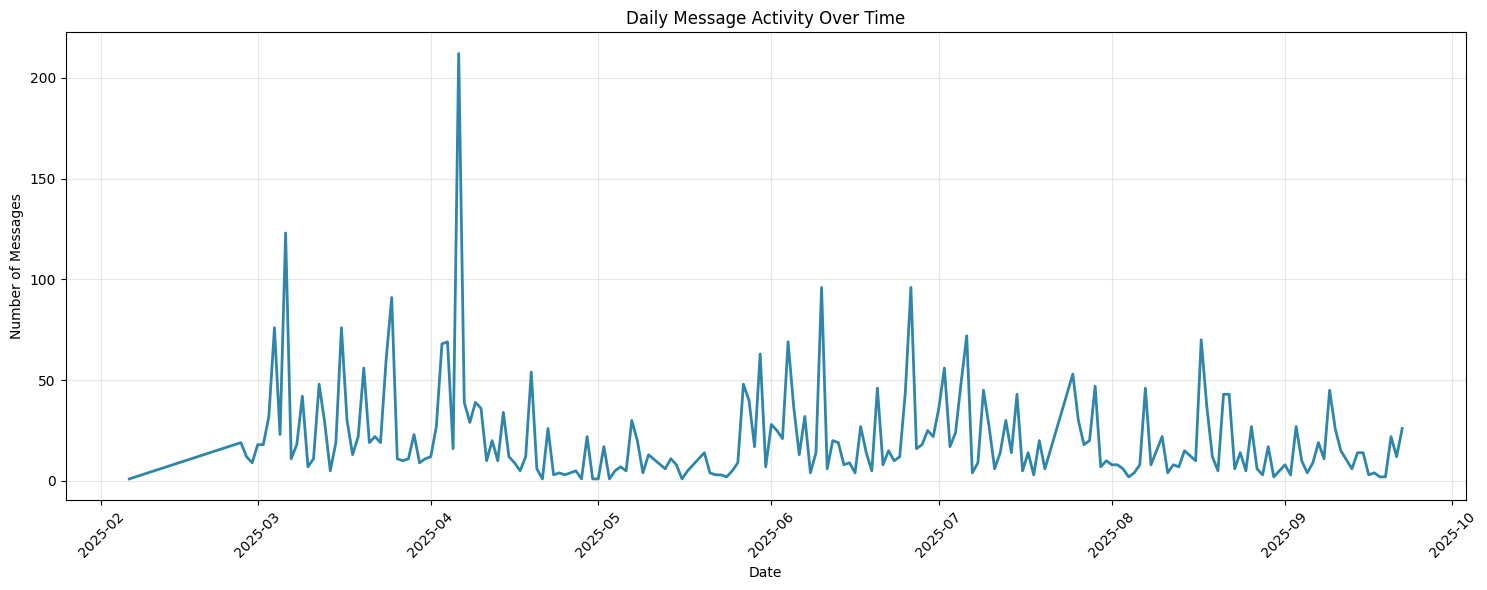

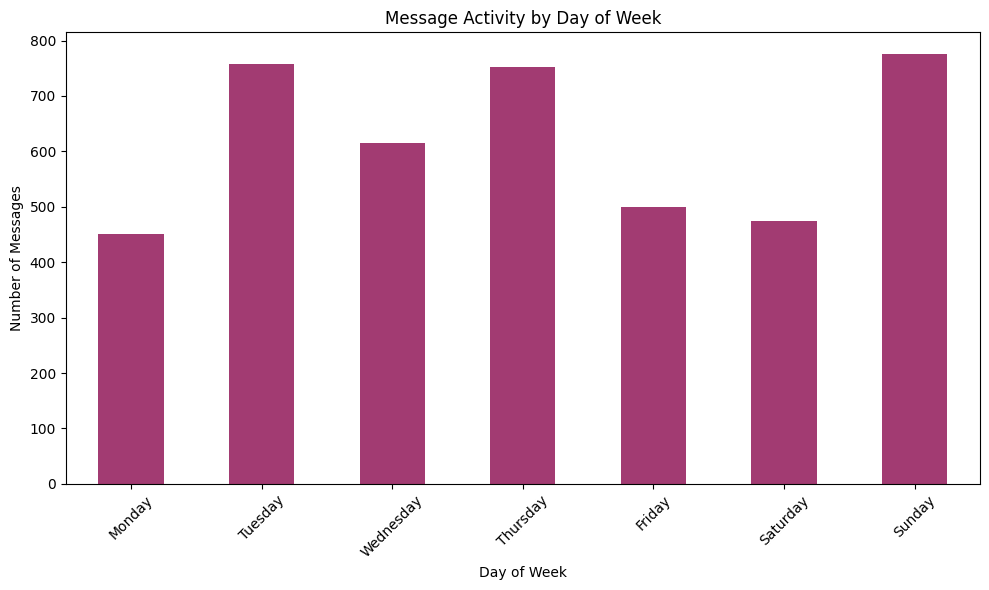

In [23]:
import matplotlib.pyplot as plt

# Temporal analysis - messages by date
df['date_only'] = df['datetime'].dt.date
daily_messages = df.groupby('date_only').size()

plt.figure(figsize=(15, 6))
daily_messages.plot(kind='line', color='#2E86AB', linewidth=2)
plt.title('Daily Message Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekly pattern
df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

weekly_pattern = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 6))
weekly_pattern.plot(kind='bar', color='#A23B72')
plt.title('Message Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

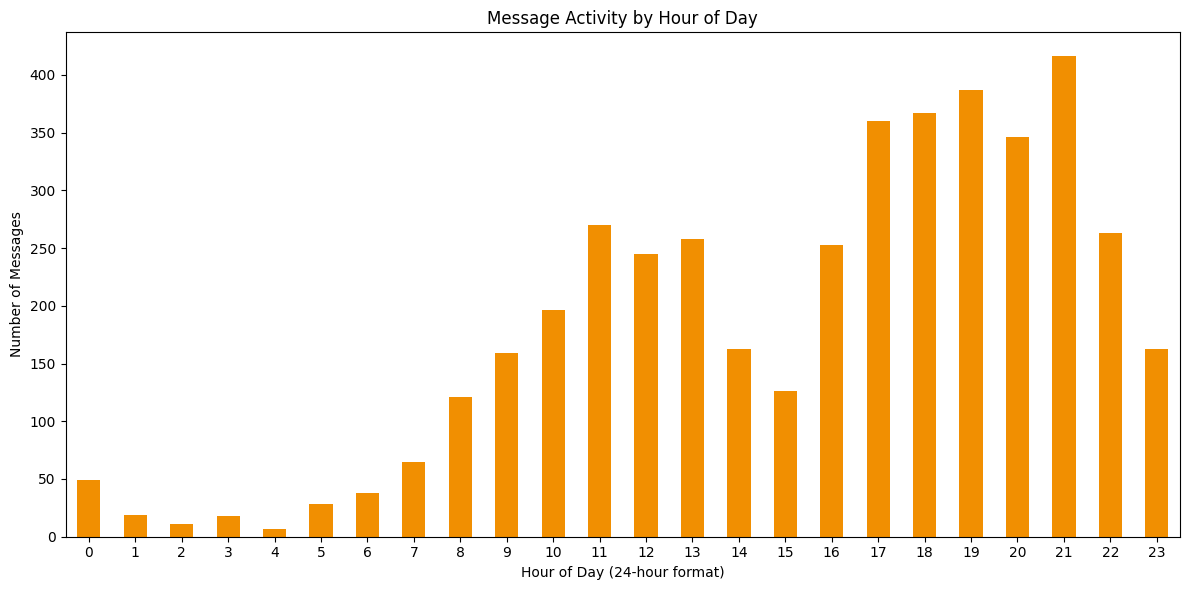

Most active hour: 21:00 (416 messages)


In [24]:
import matplotlib.pyplot as plt

# Hourly activity pattern
hourly_pattern = df['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_pattern.plot(kind='bar', color='#F18F01')
plt.title('Message Activity by Hour of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Most active hour: {hourly_pattern.idxmax()}:00 ({hourly_pattern.max()} messages)")

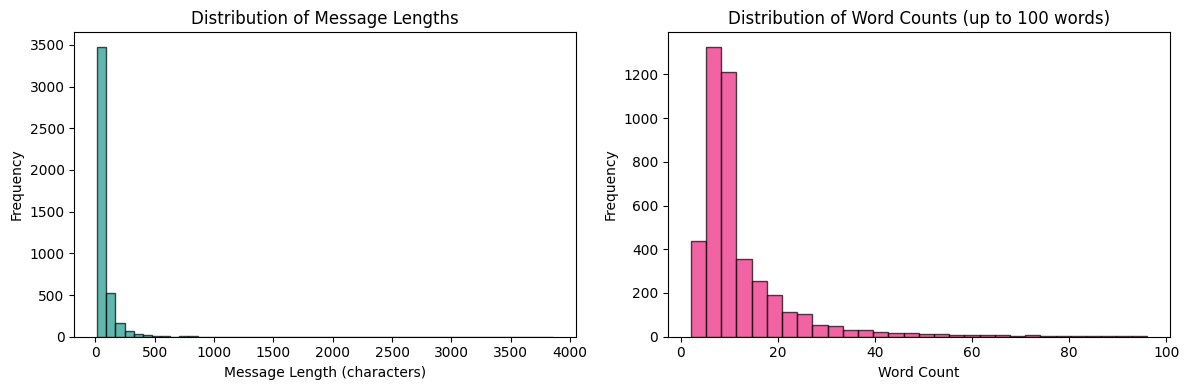

Average message length: 78.0 characters
Average word count: 13.6 words
Longest message: 3860 characters


In [25]:
import matplotlib.pyplot as plt

# Message length analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['message_length'], bins=50, color='#1B998B', alpha=0.7, edgecolor='black')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')

plt.subplot(1, 2, 2)
plt.hist(df[df['word_count'] < 100]['word_count'], bins=30, color='#ED217C', alpha=0.7, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts (up to 100 words)')

plt.tight_layout()
plt.show()

print(f"Average message length: {df['message_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Longest message: {df['message_length'].max()} characters")

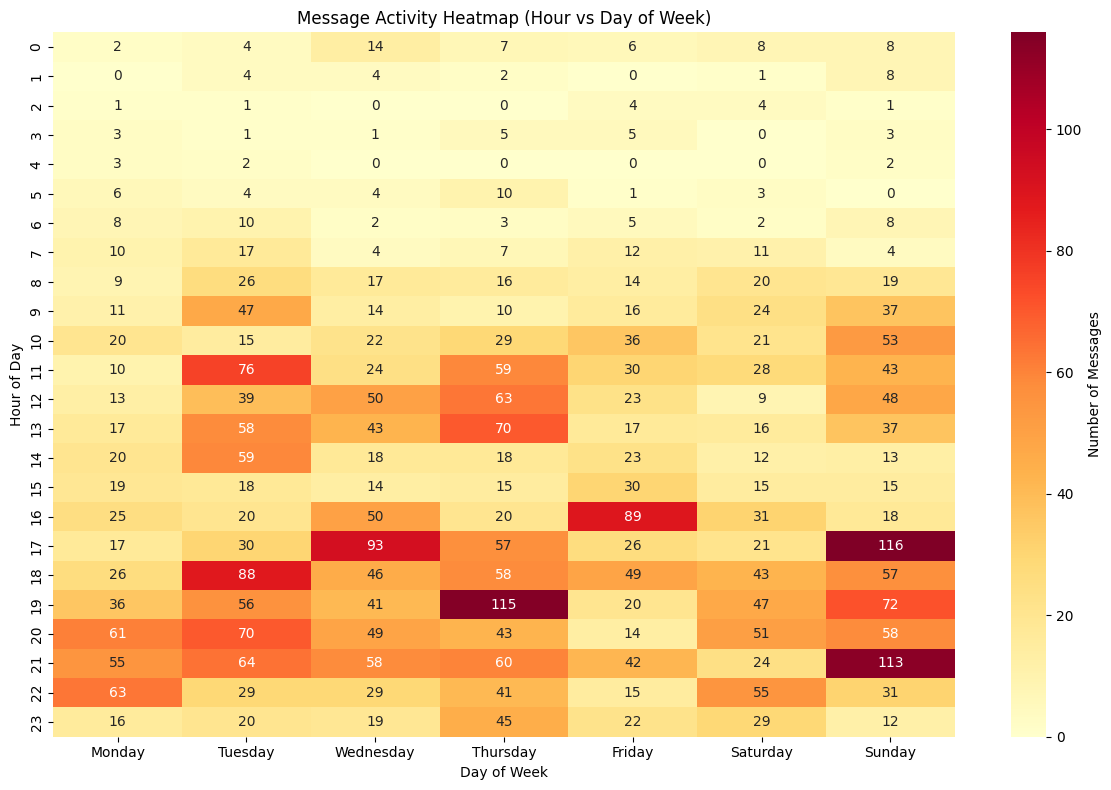

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Activity heatmap (hour vs day of week)
heatmap_data = df.pivot_table(index='hour', columns='day_of_week',
                             values='message', aggfunc='count',
                             fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[days_order]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='d',
            cbar_kws={'label': 'Number of Messages'})
plt.title('Message Activity Heatmap (Hour vs Day of Week)')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

In [27]:
# Member engagement analysis
member_stats = df.groupby('clean_sender').agg({
    'message': 'count',
    'message_length': 'mean',
    'word_count': 'mean',
    'datetime': ['min', 'max']
}).round(2)

member_stats.columns = ['total_messages', 'avg_msg_length', 'avg_word_count', 'first_seen', 'last_seen']
member_stats['days_active'] = (member_stats['last_seen'] - member_stats['first_seen']).dt.days
member_stats['msgs_per_day'] = member_stats['total_messages'] / member_stats['days_active'].clip(lower=1)

# Top engaged members (more than 10 messages)
engaged_members = member_stats[member_stats['total_messages'] > 10].sort_values('total_messages', ascending=False)

print("=== TOP ENGAGED MEMBERS ===")
print(engaged_members.head(10)[['total_messages', 'avg_msg_length', 'days_active', 'msgs_per_day']])

=== TOP ENGAGED MEMBERS ===
              total_messages  avg_msg_length  days_active  msgs_per_day
clean_sender                                                           
System                  4295           77.63          228     18.837719
User                      28          125.14          181      0.154696


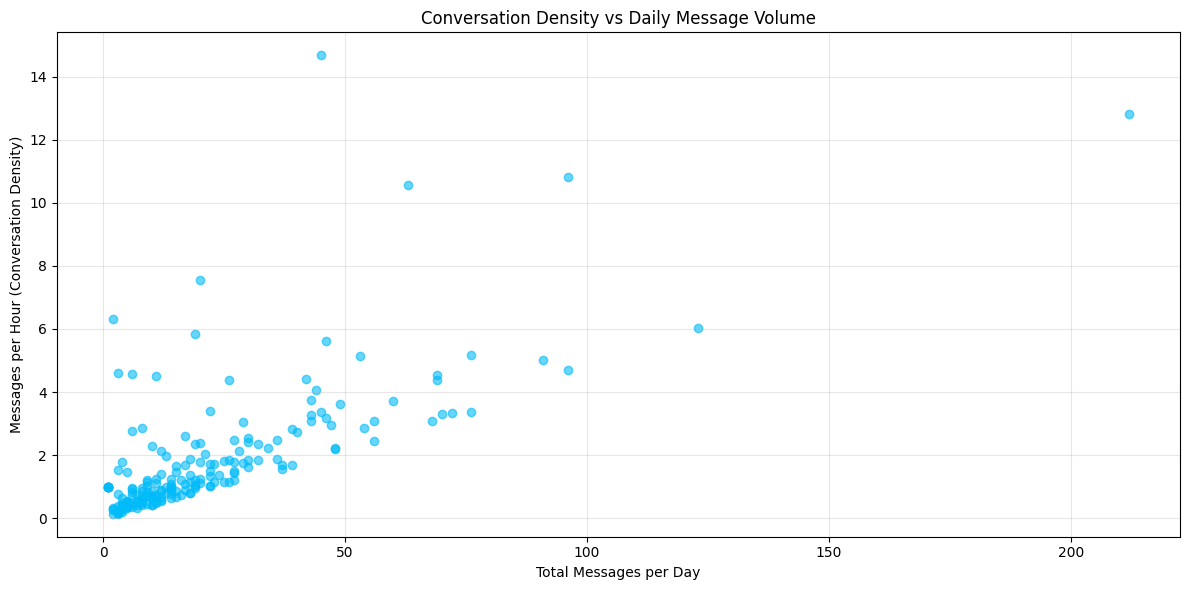

In [28]:
import matplotlib.pyplot as plt

# Response time analysis (simplified)
# Group by date and analyze conversation density
convo_density = df.groupby('date_only').agg({
    'message': 'count',
    'datetime': lambda x: (x.max() - x.min()).total_seconds() / 3600 if len(x) > 1 else 0
}).rename(columns={'message': 'msg_count', 'datetime': 'convo_duration_hrs'})

convo_density['msgs_per_hr'] = convo_density['msg_count'] / convo_density['convo_duration_hrs'].replace(0, 1)

plt.figure(figsize=(12, 6))
plt.scatter(convo_density['msg_count'], convo_density['msgs_per_hr'], alpha=0.6, color='#00BBF9')
plt.xlabel('Total Messages per Day')
plt.ylabel('Messages per Hour (Conversation Density)')
plt.title('Conversation Density vs Daily Message Volume')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Final summary statistics
print("=== COMPREHENSIVE CHAT ANALYSIS SUMMARY ===")
print(f"📊 Total Analysis Period: {(df['datetime'].max() - df['datetime'].min()).days} days")
print(f"💬 Total Messages Analyzed: {len(df):,}")
print(f"👥 Unique Participants: {df['clean_sender'].nunique()}")

url_messages = df[df['message_type'] == 'URL']
questions = df[df['message_type'] == 'Question']
technical_messages = df[df['message_type'] == 'Technical']

print(f"🔗 URLs Shared: {len(url_messages)}")
print(f"❓ Questions Asked: {len(questions)}")
print(f"🖼️ Media Files: {len(df[df['message_type'] == 'Media'])}")
print(f"⚡ Technical Discussions: {len(technical_messages)}")

top_url_sharers = url_messages['clean_sender'].value_counts().head(5)
top_questioners = questions['clean_sender'].value_counts().head(5)

print(f"\n🏆 Most Active Member: {top_senders.index[0]} ({top_senders.iloc[0]} messages)")
# Check if top_url_sharers is not empty before accessing index[0]
if not top_url_sharers.empty:
    print(f"🌐 Top URL Sharer: {top_url_sharers.index[0]} ({top_url_sharers.iloc[0]} URLs)")
else:
    print("🌐 Top URL Sharer: No URLs shared")

# Check if top_questioners is not empty before accessing index[0]
if not top_questioners.empty:
    print(f"❓ Most Curious Member: {top_questioners.index[0]} ({top_questioners.iloc[0]} questions)")
else:
    print("❓ Most Curious Member: No questions asked")


print(f"\n📈 Peak Activity Hour: {hourly_pattern.idxmax()}:00")
print(f"📅 Most Active Day: {weekly_pattern.index[0]}")
print(f"💭 Average Message Length: {df['message_length'].mean():.1f} characters")

# Community health metrics
active_days = df['date_only'].nunique()
avg_daily_msgs = len(df) / active_days
engagement_ratio = len(engaged_members) / df['clean_sender'].nunique() * 100

print(f"\n📊 Community Health Metrics:")
print(f"   Active Days: {active_days}")
print(f"   Average Daily Messages: {avg_daily_msgs:.1f}")
print(f"   Member Engagement Ratio: {engagement_ratio:.1f}%")

=== COMPREHENSIVE CHAT ANALYSIS SUMMARY ===
📊 Total Analysis Period: 228 days
💬 Total Messages Analyzed: 4,328
👥 Unique Participants: 3
🔗 URLs Shared: 258
❓ Questions Asked: 511
🖼️ Media Files: 229
⚡ Technical Discussions: 530

🏆 Most Active Member: System (4295 messages)
🌐 Top URL Sharer: System (256 URLs)
❓ Most Curious Member: System (506 questions)

📈 Peak Activity Hour: 21:00
📅 Most Active Day: Monday
💭 Average Message Length: 78.0 characters

📊 Community Health Metrics:
   Active Days: 199
   Average Daily Messages: 21.7
   Member Engagement Ratio: 66.7%
